# Notebook Hannah

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

## Hypothetisch terrein

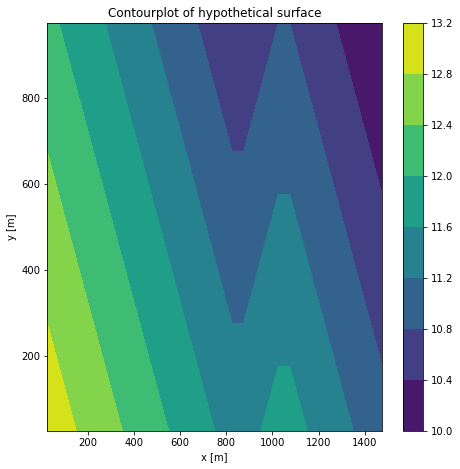

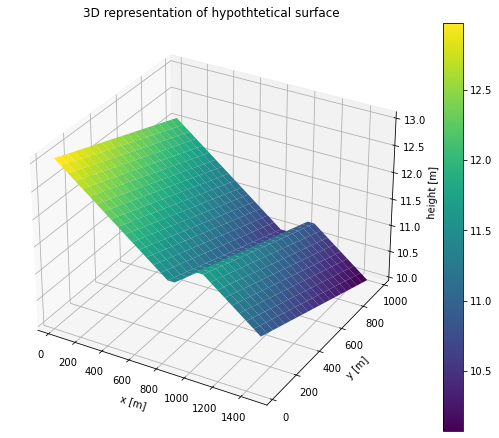

In [14]:
runfile('Grid_hypoth.py')
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

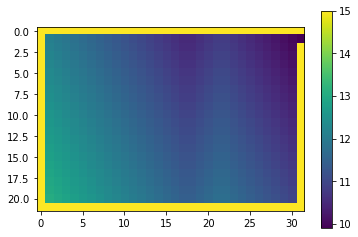

In [16]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

# Benchmark scenario

## Outflux functies
Aangepaste OutfluxNH functie voor de eerste loop; heeft geen $\Delta$t als input en berekent geen v*.

In [4]:
def OutfluxNH2_init(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

Aangepaste OutfluxNH functie voor alle overige loops; heeft $\Delta$t uit de vorige loop als input en berekent op basis van de met v gecorrigeerde v* een nieuwe $\Delta$t.

In [5]:
def OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.nanmax(vj_list) #np.nanmax om NaN waarden te negeren
    
    return Fout, vjmax_NH

## Time loop

In [71]:
# Parameters definiëren
Acell = deltax*deltay
tend = 200*60
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
deltat = 10*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:]) 
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
#depths_imag_new[-2,-1] = 0 #uitstroomcel legen

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #corrigeren voor NaN (treedt enkele keren op)
        deltat = deltax/np.nanmax(vjmax_list) #np.nanmax om NaN waarden te negeren
    print(deltat)
    t = t + deltat
    t_list.append(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #depths_imag_new[-2,-1] = 0 #uitstroomcel legen. 
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    depths_list.append(depths_imag_new)

492.8888079942049
262.60264780123094
186.0287799834935
153.56177407508628
146.34856943339844
140.2645336138491
130.17174742033194
122.3915487440302
115.93490778610972
110.33121549138019
105.05938175637002
100.98723910551955
97.14780685655
94.0569040040634
90.90105194711113
88.60259966943394
86.52351811534932
84.63768132560601
82.48092183477988
80.3418552630473
78.55545636153323
76.90432181183091
75.19322446606479
73.83242783015936
72.56369986230126
71.76338364292062
71.03257055628082
70.24381331864424
69.75949747507043
69.28734241134984
68.89198442136818
68.50936697993846
68.26226336745613
67.93319206042128
67.84862543062171
67.5677941223194
67.57746465933009
67.39089329830342
67.50588379089207
67.48031784233262
67.47630945481625
67.64521819201306
67.57300804492584
67.81103471259
67.83450122098242
68.10107798835733
68.0009698675338
67.20304459046822
68.52882572047153
67.04079551398553
68.18680624583752
66.92751600047369
67.64810024415371
66.66304744757342
66.36894787983431
65.587259607

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_79919/2238314007.py:83: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_79919/2238314007.py:84: RuntimeWarning:

invalid value encountered in sqrt



NaN probleem
65.58725960795934
65.35674019042689
65.63610451133559
65.86131248136604
66.12645138498964
66.1565807801859
67.13802486948963
66.57941720145466
67.36900372562056
66.76248030654607
67.59143372685588
67.19627859332697
67.86197270712306
67.62476104259511
68.13914880730145
68.08084091712446
68.45552611511043
68.59133599830281
68.80526679513238
69.13054123678239
69.19136498983731
68.83618291681002
69.19250182256317
69.80943195252074
70.0748791406823
70.34695388622144
70.54865507320268
70.82045706344174
71.10016021482093
71.33234791374376
71.6989585397669
71.92531272218612
NaN probleem
71.92531272218612
NaN probleem
71.92531272218612
NaN probleem
71.92531272218612
NaN probleem
71.92531272218612
73.76683810147506
74.1265456643147
74.60783512285138
74.97713344162521
75.46020234232105
75.81550236804163
76.23501991753226
76.58319078400372
77.01677516723694
77.34278088090744
77.52097903630296
77.86150392845124
78.05533516551256
78.39014359800842
76.29376326354853
77.22088351745226
78.

.........................................................

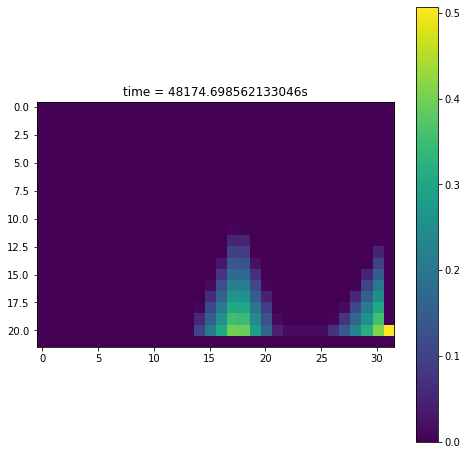

In [20]:
fps = 3
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat_vHannah_nancorr_nooutflux.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

................................................

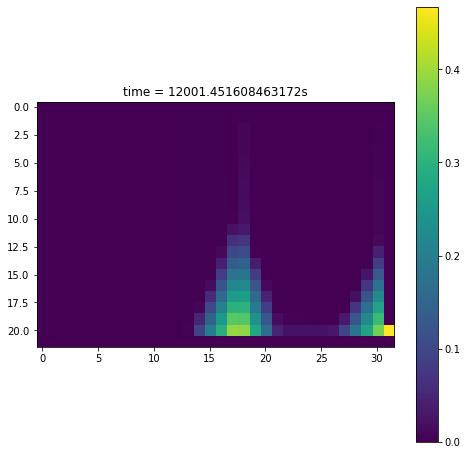

In [15]:
fps = 3
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat_vOlivier_nancorr_nooutflux.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

Proberen plotten zonder randen

.................................................

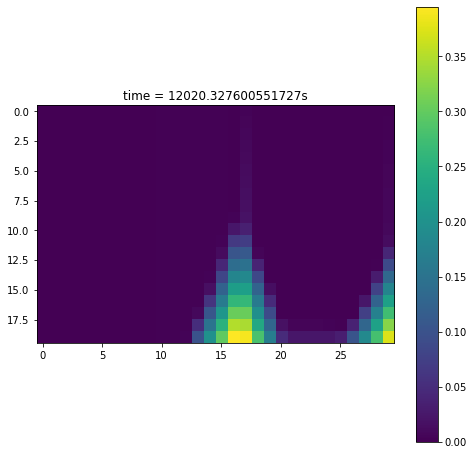

In [24]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)
#probeer te plotten zonder de randen
fps = 3
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list_bis[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list_bis[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list_bis[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat_nancorr_nooutflux_noedge.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

# Different topography ("het eiland")
## DEM
Script obtained from: https://stackoverflow.com/questions/45744603/build-a-digital-elevation-model-dem-while-controlling-number-of-mountains-and

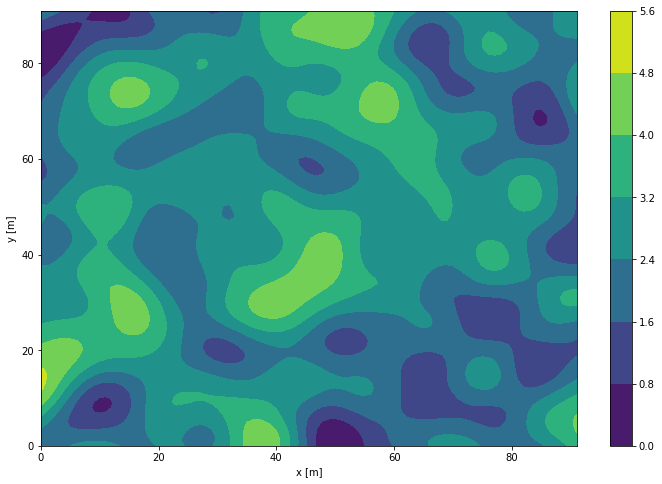

In [43]:
import numpy as np
import pandas as pd
from scipy import signal
import plotly
import plotly.graph_objs as go


def rndmtx():
    """Generate random 2d-array as a digital elevation model."""

    nx = 120
    ny = 120
    dem1 = np.random.rand(nx, ny)
    # Save array to csv file befor Gaussian filter.
    # Comment the next two lines if reading from the csv file.
    #dafr = pd.DataFrame(dem1)
    #dafr.to_csv('G_dem1.csv', header=False, index=False)

    # Uncomment the next two lines to read from csv file.
    dafr = pd.read_csv('G_dem1.csv', header=None)
    dem1 = dafr.values

    # Apply the first Gaussian filter.
    sizex = 7  # The less sizex and sizey the more highlands.
    sizey = 7  # The more sizex and sizey the more water.
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    scale = 0.33  # The more scale the bigger the difference in elevation.
    g = np.exp(-scale*(x**2/sizex+y**2/sizey))
    filter1 = g/g.sum()  # Normalise the Gaussian function.

    dem_smooth = signal.convolve(dem1, filter1, mode='valid')
    # Rescale so it lies between 0 and 1.
    dem_smooth = 5*((dem_smooth - dem_smooth.min())
                  / (dem_smooth.max() - dem_smooth.min()))

    # Apply the second Gaussian filter to make the boundaries smoother.
    sizex = 7
    sizey = 7
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.33*(x**2/sizex+y**2/sizey))
    filter2 = g/g.sum()

    dem_smooth1 = signal.convolve(dem_smooth, filter2, mode='valid')
    dem_smooth1 = 5*((dem_smooth1 - dem_smooth1.min())
                   / (dem_smooth1.max() - dem_smooth1.min()))

    return dem_smooth1

# Get the raw random array of the digital elevation model
#   and assign it to the variable.
contour_xy = rndmtx()

# Save the array into CSV file in the working directory.
df = pd.DataFrame(contour_xy)
df.to_csv('last_data.csv', header=False, index=False)

data = [
    go.Contour(
        z=contour_xy,
        colorscale=[
            [0, 'rgb(0, 161, 233)'], [0.28, 'rgb(0, 161, 233)'],
            [0.28, 'rgb(29, 210, 108)'], [0.50, 'rgb(29, 210, 108)'],
            [0.50, 'rgb(141, 232, 130)'], [0.65, 'rgb(141, 232, 130)'],
            [0.65, 'rgb(254, 254, 152)'], [0.75, 'rgb(254, 254, 152)'],
            [0.75, 'rgb(192, 182, 122)'], [0.82, 'rgb(192, 182, 122)'],
            [0.82, 'rgb(142, 110, 92)'], [0.88, 'rgb(142, 110, 92)'],
            [0.88, 'rgb(171, 147, 142)'], [0.93, 'rgb(171, 147, 142)'],
            [0.93, 'rgb(227, 219, 217)'], [0.97, 'rgb(227, 219, 217)'],
            [0.97, 'rgb(255, 255, 255)'], [1, 'rgb(255, 255, 255)']
        ],
    ),
]

layout = go.Layout(yaxis=dict(
    autorange='reversed')) 

figure = go.Figure(data=data, layout=layout)
figure.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
figure.update_xaxes(
    range=[0,90],  # sets the range of xaxis
)
figure.show()
plotly.offline.plot(figure, filename='dem.html')

ny,nx = np.shape(contour_xy)
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = contour_xy
ny,nx = np.shape(contour_xy)

# Randen op zeeniveau (hoogte 0) om eiland te simuleren
grid_imag[:,0] = 0
grid_imag[:,-1] = 0
grid_imag[0,:] = 0
grid_imag[-1,:] = 0

plt.figure(figsize= (12,8))
plt.contourf(np.flipud(contour_xy))
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('DEM_scenario3.pdf')
plt.show()

In [40]:
np.shape(contour_xy)
# Bijv. eiland van 920mx920m met een celgrootte van 10mx10m

(92, 92)

In [18]:
ny,nx = np.shape(contour_xy)
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = contour_xy

# Randen op zeeniveau (hoogte 0) om eiland te simuleren
grid_imag[:,0] = 0
grid_imag[:,-1] = 0
grid_imag[0,:] = 0
grid_imag[-1,:] = 0

#plt.imshow(grid_imag)
#plt.colorbar()

## Outflow fluxes functies
Met een Manning's coefficient van 0.03 (typisch voor kort gras).

In [24]:
def OutfluxNH2_init_eiland(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

In [25]:
def OutfluxNH2_init_eiland_randen(j,i, NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    if j==1:
        if NH_h[1]<NH_h[2]: #stijgende topografie aan rand
            NH_h[3]=10 #geen uitstroom naar zee
    elif j == ny:
        if NH_h[3]<NH_h[2]:
            NH_h[1]=10
    if i == 1:
        if NH_h[0]<NH_h[2]:
            NH_h[4]=10
    elif i == nx:
        if NH_h[4]<NH_h[2]:
            NH_h[0]=10
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list)
            
    return Fout, vmax_NH

In [26]:
def OutfluxNH2_eiland(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.nanmax(vj_list) #np.nanmax om NaN waarden te negeren
    
    return Fout, vjmax_NH

In [28]:
def OutfluxNH2_eiland_randen(j,i, NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    if j==1:
        if NH_h[1]<NH_h[2]: #stijgende topografie aan rand
            NH_h[3]=10 #geen uitstroom naar zee
    elif j == ny:
        if NH_h[3]<NH_h[2]:
            NH_h[1]=10
    if i == 1:
        if NH_h[0]<NH_h[2]:
            NH_h[4]=10
    elif i == nx:
        if NH_h[4]<NH_h[2]:
            NH_h[0]=10
    
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.03 #Manning's coefficient voor kort gras!
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(v) #AANPASSING: ENKEL WERKEN MET DE THEORERTISCHE MAX SNELHEID
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.nanmax(vj_list) #np.nanmax om NaN waarden te negeren
    
    return Fout, vjmax_NH

## Time loop

In [29]:
# Parameters definiëren
deltax = 10 #m
deltay = 10 #m
Acell = deltax*deltay
tend = 60*150
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
deltat = 1*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 1 min regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        if j==1 or j==ny or i==1 or i==nx:
            F, vmax_NH = OutfluxNH2_init_eiland_randen(j,i, NH_h, NH_d, Acell, deltax)
        else:
            F, vmax_NH = OutfluxNH2_init_eiland(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.nanmax(vmax_list[:]) #np.nanmax om NaN waarden te negeren
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
# Waterhoogtestijging in de zee is verwaarloosbaar 
depths_imag_new[:,0] = 0 
depths_imag_new[:,-1] = 0
depths_imag_new[0,:] = 0
depths_imag_new[-1,:] = 0

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
elif t > duration and (t-deltat) < duration:
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            if j==1 or j==ny or i==1 or i==nx:
                F, vjmax_NH = OutfluxNH2_eiland_randen(j,i, NH_h, NH_d, Acell, deltat, deltax) #!
            else:
                F, vjmax_NH = OutfluxNH2_eiland(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    #if not(np.isnan(np.max(vjmax_list))): #corrigeren voor NaN
        #deltat = deltax/np.max(vjmax_list) 
    #else:
        #print('Probleem met NaN')
    deltat = deltax/np.nanmax(vjmax_list) #np.nanmax om NaN waarden te negeren
    print(deltat)
    t = t + deltat
    t_list.append(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    # Waterhoogtestijging in de zee is verwaarloosbaar 
    depths_imag_new[:,0] = 0 
    depths_imag_new[:,-1] = 0
    depths_imag_new[0,:] = 0
    depths_imag_new[-1,:] = 0

    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    elif t > duration and (t-deltat) < duration:
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
    depths_list.append(depths_imag_new)

174.87435419566722
81.40674377872453
70.23325440511984
64.90125615230973
55.028738641923894
46.97376761895972
41.15631942131997
37.81589566111052
34.65300028863031
32.42366708910291
30.973759201802977
30.040846075459648
29.820816107255915


/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1151600139.py:84: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1151600139.py:85: RuntimeWarning:

invalid value encountered in sqrt

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1151600139.py:96: RuntimeWarning:

All-NaN axis encountered



29.471625289654867
28.799492785068328
28.256290067681398
28.045065860865027
27.905741468040212
27.69008954963496
27.47709056637913
26.901827151964497
26.252055122854227
25.823200611953883
25.452322416109016
25.070194286727173
24.72517205867481
24.41198668135554
24.11668552007536
23.84208062120851
23.60635971927142
23.401760856142126
23.121285190075007
22.74546316826252
22.484963720063764
22.25725842124373
22.00852867872029
21.82766309781595
21.65348061940392
21.48036370866145
21.342031128938405
21.208748785850222
21.092854088480014
20.997582462411945
20.905152115013014
20.826354482326067
20.823285865307557
20.763144982568107


/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1211989900.py:96: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1211989900.py:97: RuntimeWarning:

invalid value encountered in sqrt

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_18756/1211989900.py:108: RuntimeWarning:

All-NaN axis encountered



20.700629240670743
20.680996548103195
20.63316555455267
20.58470924534144
20.55821709056406
20.51625987996584
20.476325219398298
20.443291538642207
20.404371638623466
20.369882768173362
20.338293305277553
20.305000814107366
20.27670875685268
20.250019093643246
20.223446105215114
20.200885996689742
20.04114281056159
19.871040548673736
19.687393507643314
19.99910067850455
19.48467863314365
19.935371095999614
19.254352611748114
19.73561834740815
19.004384528702218
19.50888433693023
18.75660896216782
19.309394724691394
18.5184437917388
19.111232392012546
18.201895304330005
18.865626633557763
17.895812310084953
18.50472866541639
17.730620777125225
18.27608284549723
17.496351469120103
18.08931859002951
17.235527583159758
17.98428644301466
16.99806778892261
17.66849278333573
16.768950221374062
17.636609151499304
16.903373721510352
17.59343288913972
16.70971341032771
17.452789265047343
16.54797966365237
17.298330750415467
16.401227898633085
17.238485678186333
16.26998666786961
17.0775387895302

## Visualisatie

Animatie:

....................Gif opgeslaan als eiland_randencorr_verslag_150min


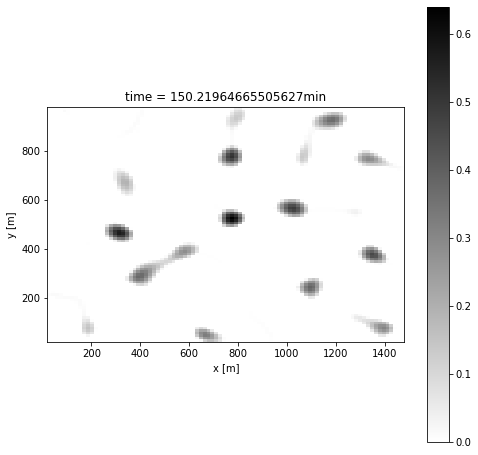

In [30]:
# Gif functie zonder flipud
def gif_maken_bis(layers, tijdstappen, fps, naam_file):
    fig, ax = plt.subplots(figsize = (8,8))
    a = layers[0]
    im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(layers[:]), cmap = 'binary', 
    extent= [np.min(xs)-deltax/2, np.max(xs)+deltax/2, 
    np.min(ys)-deltay/2,np.max(ys)+deltay/2]) #zonder flipud() om overeenkomst met dem.html te verkrijgen
    plt.colorbar(im)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(layers[i]) #zonder flipud()
        ax.set_title('time = '+str(tijdstappen[i]/60) + 'min')
    
        return [im]

    anim = animation.FuncAnimation(fig, animate_func, frames = len(layers), interval = 1000 / fps) # in ms)
    anim.save(naam_file+'.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])        
    print("Gif opgeslaan als "+naam_file)
    
# Randen verwijderen
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)

# Gif maken
gif_maken_bis(depths_list_bis, t_list, 20, 'eiland_randencorr_verslag_150min')

Figuur die het verloop van de waterdiepte in de tijd weergeeft voor een willekeurige helling en vallei in het heuvellandschap:

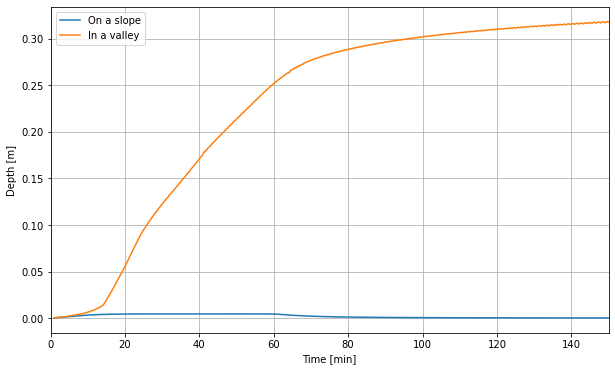

In [31]:
t_min_list = []
depths_slope_list = []
depths_valley_list = []
for i in range(len(t_list)):
    t_min_list.append(t_list[i]/60) #omgezet naar minuten
    depth_slope = depths_list_bis[i][6,56] #waterdiepte op een helling
    depths_slope_list.append(depth_slope)
    depth_valley = depths_list_bis[i][5,71] #waterdiepte in een vallei
    depths_valley_list.append(depth_valley)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_min_list, depths_slope_list, label = 'On a slope')
plt.plot(t_min_list, depths_valley_list, label = 'In a valley')
plt.xlim((0, 150))
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
#plt.title(r'Water depth on a slope and in a valley')
plt.legend()
#plt.savefig('eiland_slope_valley.png', dpi=1000)
plt.savefig('eiland_slope_valley.pdf')

Figuur die het grid plot op twee interessante tijdstippen: bijv. na 30 en 90 min.

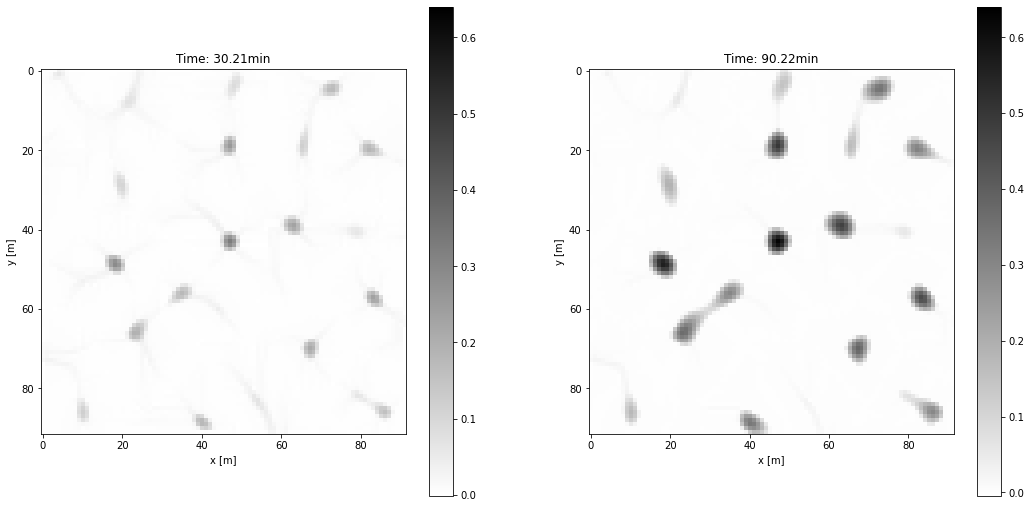

In [32]:
times_interest = [30*60,90*60]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list) > times_interest[i])
    locs.append(locations[0][0])

max_depth = np.max(depths_list_bis[:])

plt.figure(figsize = (18,9))
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_bis[locs[i]]
    plt.imshow(hoogtes, vmax = max_depth, cmap = 'binary')
    plt.colorbar()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Time: '+ str(np.round(t_list[locs[i]]/60,2)) + 'min')
    #plt.savefig("eiland_30min_90min.png", dpi=1200)
    plt.savefig('eiland_30min_90min.pdf')